# Analysing Google Trends data during the Australian same sex marriage survey

Australia is currently facing a single issue postal survey on gay marriage. 

Gay marriage has been polled extensively in Australia, suggesting majority support for the change in law. However, there are a number of reasons why polling data may not be a suitable predictor of the outcome of the postal survey. Among these are:
* Unlike regular elections in Australia, the postal survey is voluntary. Australia has virtually no historical data on intent to participate, as participation is compulsory and rates are high. This makes any polling difficult to weight to likely participation.
* Unlike voting intention polls, which can be calibrated to real election data every few years, social issue polling can almost never be calibrated
* [The 'Bradley Effect'](https://en.wikipedia.org/wiki/Bradley_effect)

This notebook investigates using Google Trends data as a monitor of popular interest in Australia for the 'yes' and 'no' cases. It was inspired by a similar exercise conducted for the Irish referendum on gay marriage, which you can read about [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2674243).

https://code.tutsplus.com/tutorials/creating-a-web-app-from-scratch-using-python-flask-and-mysql--cms-22972

First some housekeeping to install/call the necessary packages:

In [1]:
!pip install pytrends
from pytrends.request import TrendReq
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
result = pd.DataFrame

## Downloading the data
First of all we define the time periods that bound our data request to Google Trends.

In [2]:
# Define date to string formatter function
def date_to_string(datetimevar, form='%Y-%m-%dT%H'):
    t = pd.to_datetime(str(datetimevar)) 
    timestring = t.strftime(form)
    return timestring

# Set start date for data collection (end date is today)
start_date = '2017-07-01T00:00'
start_date = np.datetime64(start_date)
end_date = np.datetime64('now')
end_date = np.datetime64(date_to_string(end_date, form='%Y-%m-%d'))

# Count number of days between start and end
delta_days = np.timedelta64(end_date - start_date, 'D')
delta_days = (delta_days/np.timedelta64(1, 'D')).astype(int)
print("Number of days: ", delta_days+1)

Number of days:  65


We then call the Google Trends API using the `pytrends` package.

Google Trends allows us to download data for a defined time period. As the period gets larger, the granularity of the data reduces. We want data at approximately the hourly basis to give us an interesting enough look into search behaviour.

Google Trends will return data that indexes each search term to 100. This is insufficient for time lapse data - we will need to find a method to scale each batch proportionately to the previous batch. This means each batch will need some overlapping data to calculate this scalar.

The code block below batches the requests into batches of 5.5 days, providing us with sufficient overlap to scale each batch proportionately to the previous bathc.

In [3]:
# Login to Google. Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq()

for i in range(0,delta_days+1):
    start = start_date+np.timedelta64(i, 'D')
    finish = start_date+np.timedelta64(i+5, 'D')
    # reformat to Google format
    start = date_to_string(start)
    finish = date_to_string(finish, form='%Y-%m-%dT12') #extend finish time by 14 hours for sufficient overlap to calibrate chain
    chainlink = i
    #print("start: ", start, "finish: ", finish, "chainlink: ", chainlink)
    pytrend.build_payload(kw_list=['vote yes', 'vote no'], timeframe='%s %s' % (start, finish), geo='AU')
    interest_over_time_df = pytrend.interest_over_time()
    interest_over_time_df["chainlink"] = chainlink
    if i==0:
        result = interest_over_time_df
    else:
        result = pd.concat([result, interest_over_time_df])
#print("Collected %f batches of data from Google Trends." % max(result['chainlink'])+1max(result['chainlink'])+1)

Now we need to calculate the scalars to calculate the right weights that link each portion of the data chain together.

In [4]:
# initialise scalar column
result['scalar'] = 1

# initialise scalar array for storying chain scalars
scalar = np.zeros((delta_days+1,2))
scalar[0,] = 1
for i in range(1,delta_days+1):
    # filter each adjacent chainlink to overlapping time slots
    chain_a = result[result['chainlink']==i-1]
    chain_b = result[result['chainlink']==i]
    chain_a_filter = chain_a[chain_a.index.isin(chain_b.index)]
    chain_b_filter = chain_b[chain_b.index.isin(chain_a.index)]        
    
    # calculate means of scalars on both 'vote yes' and 'vote no' searches
    yes_prop = (chain_a_filter['vote yes'] / chain_b_filter['vote yes'])
    no_prop = (chain_a_filter['vote no'] / chain_b_filter['vote no'])
    yes_prop[np.isinf(yes_prop)] = np.nan
    no_prop[np.isinf(no_prop)] = np.nan
    props = pd.concat([yes_prop, no_prop])
    
    #store scalars in scalar array
    scalar[i,0] = props.mean()

We then normalize those scalars sequentially to produce an index we can calculate a time series for.

In [5]:
# normalize scalars to index    
scalar[0,1] = 100
for i in range(1,delta_days+1):
    scalar[i,1] = scalar[i-1,1] * scalar[i,0]

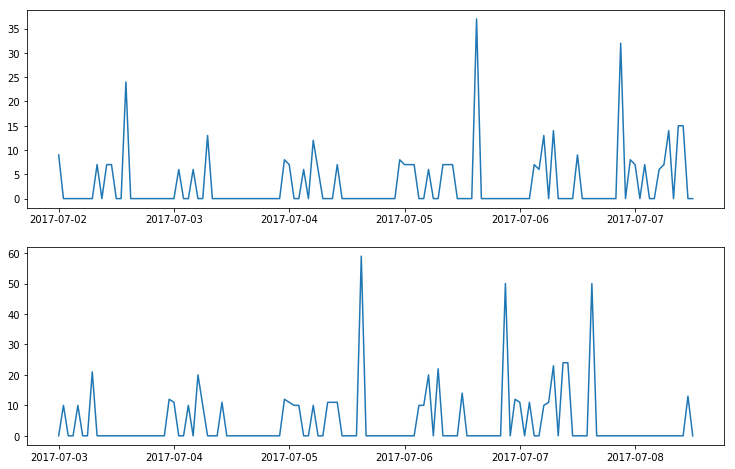

In [6]:
# Run diagnostic charts
i = 2
chain_a = result[result['chainlink']==i-1]
chain_b = result[result['chainlink']==i]
chain_a_filter = chain_a[chain_a.index.isin(chain_b.index)]
chain_b_filter = chain_b[chain_b.index.isin(chain_a.index)]
#print(chain_a_filter)
#print(chain_b_filter)
# diagnostic plots
figsize(12.5,8)
plt.subplot(211)
plt.plot(chain_a['vote yes'])
plt.subplot(212)
plt.plot(chain_b['vote yes']);


In [7]:
result.head()

,vote yes,vote no,isPartial,chainlink,scalar
date,,,,,
2017-07-01 00:00:00,9,0,False,0,1
2017-07-01 01:00:00,0,17,False,0,1
2017-07-01 02:00:00,8,8,False,0,1
2017-07-01 03:00:00,0,17,False,0,1
2017-07-01 04:00:00,0,8,False,0,1


In [8]:
# Adjust dataframe
for i in range(delta_days+1):
    result.ix[result.chainlink==i, 'normalized_yes'] = result.ix[result.chainlink==i, 'vote yes'] * scalar[i,1]
    result.ix[result.chainlink==i, 'normalized_no'] = result.ix[result.chainlink==i, 'vote no'] * scalar[i,1]
result_filtered = result.drop_duplicates()

In [9]:
result_filtered = result_filtered.sort_index()

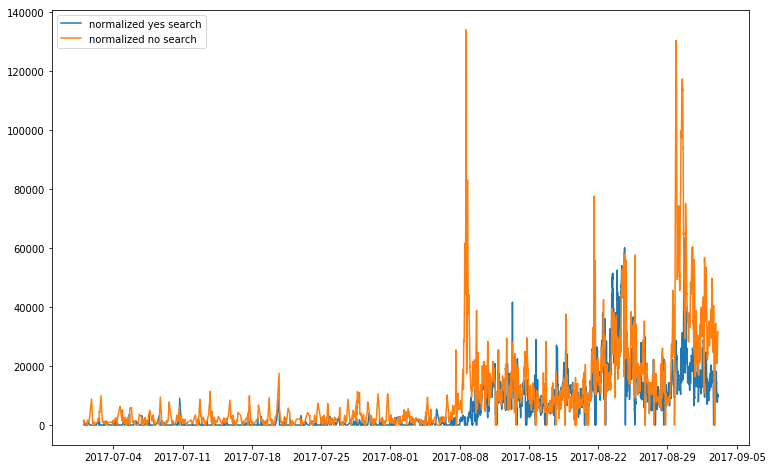

In [10]:
figsize(12.5,8)
plt.plot(result_filtered['normalized_yes'], label="normalized yes search")
plt.plot(result_filtered['normalized_no'], label="normalized no search")
plt.legend(loc="upper left");

In [11]:
#result_filtered.groupby(result_filtered.map(lambda x: x.year))
result_filtered_grouped = pd.groupby(result_filtered,by=[result_filtered.index.year, result_filtered.index.month, result_filtered.index.day]).sum()
result_filtered_grouped = result_filtered_grouped.reset_index()

In [12]:
result_filtered_grouped.head()

,level_0,level_1,level_2,vote yes,vote no,chainlink,scalar,normalized_yes,normalized_no
0,2017,7,1,46,231,0,13,4600.000000,23100.000000
1,2017,7,2,108,578,13,23,10800.000000,57800.000000
2,2017,7,3,119,292,28,26,9953.999281,24206.488720
3,2017,7,4,187,1461,83,51,16185.874754,125617.795929
4,2017,7,5,305,1429,130,52,26579.464559,124493.077530


In [13]:
result_filtered_grouped['date'] = pd.to_datetime(result_filtered_grouped['level_0'] * 10000 + result_filtered_grouped['level_1'] * 100 + result_filtered_grouped['level_2'], format="%Y%m%d")
result_filtered_grouped.set_index('date', inplace=True)
result_filtered_grouped = result_filtered_grouped[['normalized_yes', 'normalized_no']]
result_filtered_grouped.head()

,normalized_yes,normalized_no
date,,
2017-07-01,4600.000000,23100.000000
2017-07-02,10800.000000,57800.000000
2017-07-03,9953.999281,24206.488720
2017-07-04,16185.874754,125617.795929
2017-07-05,26579.464559,124493.077530


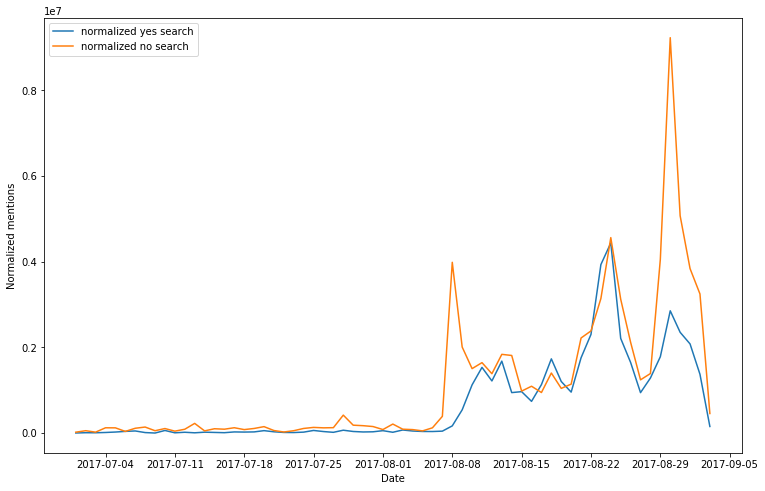

In [14]:
figsize(12.5,8)
plt.plot(result_filtered_grouped['normalized_yes'], label="normalized yes search")
plt.plot(result_filtered_grouped['normalized_no'], label="normalized no search")
plt.xlabel("Date")
plt.ylabel("Normalized mentions")
plt.legend(loc="upper left");


/home/nbuser/anaconda3_431/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()


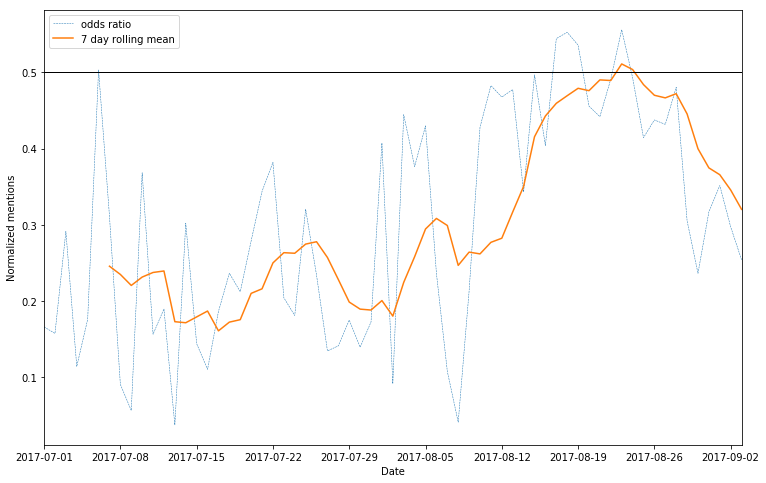

In [41]:
result_filtered_grouped['odds'] = result_filtered_grouped['normalized_yes'] / (result_filtered_grouped['normalized_yes'] + result_filtered_grouped['normalized_no'])

figsize(12.5,8)
plt.plot(result_filtered_grouped['odds'], label="odds ratio", linestyle="--", lw=0.5)
plt.plot(pd.rolling_mean(result_filtered_grouped['odds'], 7), label="7 day rolling mean")
plt.plot(result_filtered_grouped.index.values, np.repeat(0.5, len(result_filtered_grouped.index)), color="k", lw=1)
plt.xlim(result_filtered_grouped.index.values[0], result_filtered_grouped.index.values[len(result_filtered_grouped.index)-1])
plt.ylim=(0,0.3)
plt.xlabel("Date")
plt.ylabel("Normalized mentions")
plt.legend(loc="upper left")
plt.show();


Check the chain linking

In [16]:
def makerequest():
    pytrend = TrendReq()
    i=50
    start = start_date+np.timedelta64(i, 'D')
    finish = start_date+np.timedelta64(i+1, 'D')
    start = date_to_string(start)
    finish = date_to_string(finish, form='%Y-%m-%dT14') #extend finish time by 12 hours for sufficient overlap to calibrate chain
    pytrend.build_payload(kw_list=['vote yes', 'vote no'], timeframe='%s %s' % (start, finish), geo='AU')
    pytrend.interest_over_time()